# Analysis of Bitcoin Sample Data

# Convert .dat file to text file for analysis
This code is provided from the GitHub repository. It converts the dat file into an text file which will contain block and transaction information. We will grab the block's hashes and then use those hashes to look up more data about the block via an API.

### Define Functions

In [ ]:
# -*- coding: utf-8 -*-
#
# Blockchain parser
# Copyright (c) 2015-2023 Denis Leonov <466611@gmail.com>
#

import os
import datetime
import hashlib
import binascii

def reverse(input):
    L = len(input)
    if (L % 2) != 0:
        return None
    else:
        Res = ''
        L = L // 2
        for i in range(L):
            T = input[i*2] + input[i*2+1]
            Res = T + Res
            T = ''
        return (Res);

def merkle_root(lst): # https://gist.github.com/anonymous/7eb080a67398f648c1709e41890f8c44
    sha256d = lambda x: hashlib.sha256(hashlib.sha256(x).digest()).digest()
    hash_pair = lambda x, y: sha256d(x[::-1] + y[::-1])[::-1]
    if len(lst) == 1: return lst[0]
    if len(lst) % 2 == 1:
        lst.append(lst[-1])
    return merkle_root([hash_pair(x,y) for x, y in zip(*[iter(lst)]*2)])

def read_bytes(file,n,byte_order = 'L'):
    data = file.read(n)
    if byte_order == 'L':
        data = data[::-1]
    data = data.hex().upper()
    return data

def read_varint(file):
    b = file.read(1)
    bInt = int(b.hex(),16)
    c = 0
    data = ''
    if bInt < 253:
        c = 1
        data = b.hex().upper()
    if bInt == 253: c = 3
    if bInt == 254: c = 5
    if bInt == 255: c = 9
    for j in range(1,c):
        b = file.read(1)
        b = b.hex().upper()
        data = b + data
    return data

def convert_hex_to_btc(hex_value):
    # Convert hex value to integer
    satoshi_value = int(hex_value, 16)

    # Convert satoshi value to BTC
    btc_value = satoshi_value / 100000000

    return btc_value

In [ ]:
dirA = './' # Directory where blk*.dat files are stored
#dirA = sys.argv[1]
dirB = '/Result Blocks' # Directory where to save parsing results
#dirA = sys.argv[2]

fList = os.listdir(dirA)
fList = [x for x in fList if (x.endswith('.dat') and x.startswith('blk'))]
fList.sort()

for i in fList:
    nameSrc = i
    nameRes = nameSrc.replace('.dat','.txt')
    resList = []
    a = 0
    t = dirA + nameSrc
    resList.append('Start ' + t + ' in ' + str(datetime.datetime.now()))
    print ('Start ' + t + ' in ' + str(datetime.datetime.now()))
    f = open(t,'rb')
    tmpHex = ''
    fSize = os.path.getsize(t)
    while f.tell() != fSize:
        tmpHex = read_bytes(f,4)
        resList.append('Magic number = ' + tmpHex)
        tmpHex = read_bytes(f,4)
        resList.append('Block size = ' + tmpHex)
        tmpPos3 = f.tell()
        tmpHex = read_bytes(f,80,'B')
        tmpHex = bytes.fromhex(tmpHex)
        tmpHex = hashlib.new('sha256', tmpHex).digest()
        tmpHex = hashlib.new('sha256', tmpHex).digest()
        tmpHex = tmpHex[::-1]        
        tmpHex = tmpHex.hex().upper()
        resList.append('SHA256 hash of the current block hash = ' + tmpHex)
        f.seek(tmpPos3,0)
        tmpHex = read_bytes(f,4)
        resList.append('Version number = ' + tmpHex)
        tmpHex = read_bytes(f,32)
        resList.append('SHA256 hash of the previous block hash = ' + tmpHex)
        tmpHex = read_bytes(f,32)
        resList.append('MerkleRoot hash = ' + tmpHex)
        MerkleRoot = tmpHex
        tmpHex = read_bytes(f,4)
        resList.append('Time stamp = ' + tmpHex)
        tmpHex = read_bytes(f,4)
        resList.append('Difficulty = ' + tmpHex)
        tmpHex = read_bytes(f,4)
        resList.append('Random number = ' + tmpHex)
        tmpHex = read_varint(f)
        txCount = int(tmpHex,16)
        resList.append('Transactions count = ' + str(txCount))
        resList.append('')
        tmpHex = ''; RawTX = ''; tx_hashes = []
        for k in range(txCount):
            tmpHex = read_bytes(f,4)
            resList.append('TX version number = ' + tmpHex)
            RawTX = reverse(tmpHex)
            tmpHex = ''
            Witness = False
            b = f.read(1)
            tmpB = b.hex().upper()
            bInt = int(b.hex(),16)
            if bInt == 0:
                tmpB = ''
                f.seek(1,1)
                c = 0
                c = f.read(1)
                bInt = int(c.hex(),16)
                tmpB = c.hex().upper()
                Witness = True
            c = 0
            if bInt < 253:
                c = 1
                tmpHex = hex(bInt)[2:].upper().zfill(2)
                tmpB = ''
            if bInt == 253: c = 3
            if bInt == 254: c = 5
            if bInt == 255: c = 9
            for j in range(1,c):
                b = f.read(1)
                b = b.hex().upper()
                tmpHex = b + tmpHex
            inCount = int(tmpHex,16)
            resList.append('Inputs count = ' + tmpHex)
            tmpHex = tmpHex + tmpB
            RawTX = RawTX + reverse(tmpHex)
            for m in range(inCount):
                tmpHex = read_bytes(f,32)
                resList.append('TX from hash = ' + tmpHex)
                RawTX = RawTX + reverse(tmpHex)
                tmpHex = read_bytes(f,4)                
                resList.append('N output = ' + tmpHex)
                RawTX = RawTX + reverse(tmpHex)
                tmpHex = ''
                b = f.read(1)
                tmpB = b.hex().upper()
                bInt = int(b.hex(),16)
                c = 0
                if bInt < 253:
                    c = 1
                    tmpHex = b.hex().upper()
                    tmpB = ''
                if bInt == 253: c = 3
                if bInt == 254: c = 5
                if bInt == 255: c = 9
                for j in range(1,c):
                    b = f.read(1)
                    b = b.hex().upper()
                    tmpHex = b + tmpHex
                scriptLength = int(tmpHex,16)
                tmpHex = tmpHex + tmpB
                RawTX = RawTX + reverse(tmpHex)
                tmpHex = read_bytes(f,scriptLength,'B')
                resList.append('Input script = ' + tmpHex)
                RawTX = RawTX + tmpHex
                tmpHex = read_bytes(f,4,'B')
                resList.append('Sequence number = ' + tmpHex)
                RawTX = RawTX + tmpHex
                tmpHex = ''
            b = f.read(1)
            tmpB = b.hex().upper()
            bInt = int(b.hex(),16)
            c = 0
            if bInt < 253:
                c = 1
                tmpHex = b.hex().upper()
                tmpB = ''
            if bInt == 253: c = 3
            if bInt == 254: c = 5
            if bInt == 255: c = 9
            for j in range(1,c):
                b = f.read(1)
                b = b.hex().upper()
                tmpHex = b + tmpHex
            outputCount = int(tmpHex,16)
            tmpHex = tmpHex + tmpB
            resList.append('Outputs count = ' + str(outputCount))
            RawTX = RawTX + reverse(tmpHex)
            for m in range(outputCount):
                tmpHex = read_bytes(f,8)
                Value = tmpHex
                RawTX = RawTX + reverse(tmpHex)
                tmpHex = ''
                b = f.read(1)
                tmpB = b.hex().upper()
                bInt = int(b.hex(),16)
                c = 0
                if bInt < 253:
                    c = 1
                    tmpHex = b.hex().upper()
                    tmpB = ''
                if bInt == 253: c = 3
                if bInt == 254: c = 5
                if bInt == 255: c = 9
                for j in range(1,c):
                    b = f.read(1)
                    b = b.hex().upper()
                    tmpHex = b + tmpHex
                scriptLength = int(tmpHex,16)
                tmpHex = tmpHex + tmpB
                RawTX = RawTX + reverse(tmpHex)
                tmpHex = read_bytes(f,scriptLength,'B')
                resList.append('Value = ' + Value)
                resList.append('Output script = ' + tmpHex)
                RawTX = RawTX + tmpHex
                tmpHex = ''
            if Witness == True:
                for m in range(inCount):
                    tmpHex = read_varint(f)
                    WitnessLength = int(tmpHex,16)
                    for j in range(WitnessLength):
                        tmpHex = read_varint(f)
                        WitnessItemLength = int(tmpHex,16)
                        tmpHex = read_bytes(f,WitnessItemLength)
                        resList.append('Witness ' + str(m) + ' ' + str(j) + ' ' + str(WitnessItemLength) + ' ' + tmpHex)
                        tmpHex = ''
            Witness = False
            tmpHex = read_bytes(f,4)
            resList.append('Lock time = ' + tmpHex)
            RawTX = RawTX + reverse(tmpHex)
            tmpHex = RawTX
            tmpHex = bytes.fromhex(tmpHex)
            tmpHex = hashlib.new('sha256', tmpHex).digest()
            tmpHex = hashlib.new('sha256', tmpHex).digest()
            tmpHex = tmpHex[::-1]
            tmpHex = tmpHex.hex().upper()
            resList.append('TX hash = ' + tmpHex)
            tx_hashes.append(tmpHex)
            resList.append(''); tmpHex = ''; RawTX = ''
        a += 1
        tx_hashes = [bytes.fromhex(h) for h in tx_hashes]
        tmpHex = merkle_root(tx_hashes).hex().upper()
        if tmpHex != MerkleRoot:
            print ('Merkle roots does not match! >',MerkleRoot,tmpHex)
    f.close()
    f = open(nameRes,'w')
    for j in resList:
        f.write(j + '\n')
    f.close()

# Grab Block Hashes


In [ ]:
import pandas as pd
import re

def get_total_input_value(tx):
    # You need access to the blockchain data to get the actual input values
    return 0

def get_total_output_value(tx):
    outputs = re.findall(r'Value = (\w+)', tx)
    return sum(int(output, 16) for output in outputs)

def parse_block_data(block_data):
    def extract(pattern, text):
        match = re.search(pattern, text)
        return match.group(1) if match else None

    current_block_hash = extract(r'SHA256 hash of the current block hash = (\w+)', block_data)
    timestamp = extract(r'Time stamp = (\w+)', block_data)

    return {
        'current_block_hash': current_block_hash,
        'timestamp': timestamp,
    }

# Path to your text file
file_path = 'blk01700.txt'

# Read the text file and split into blocks
with open(file_path, 'r') as file:
    file_content = file.read()
    blocks = file_content.split('\n\n')  # Assuming each block is separated by two newlines

# Parse each block and store the data in a list
block_data_list = [parse_block_data(block) for block in blocks if block.strip()]

# Create a DataFrame
block_df = pd.DataFrame(block_data_list)
block_df = block_df.dropna()

In [ ]:
block_df

# Call Blockchain.com Blockchain Data API to Build Dataframe
- Here we're calling the blockchain.com API Blockchain Data API to grab block data. It returns a JSON File that contains info related to the block and all of the transaction data in the block. 

- To get the transaction output value we sum the value of all the transactions in each block.

- To get the estimated transaction fees we sum the value of all fees that are in each transaction.
- **We grab data from the API because it was much easier to grab the data by hash from an API. Determining transaction fees is not straightforward in the transaction data from the block. Much fewer lines of code.**

In [87]:
import requests
import datetime
import pandas as pd
import time

def timestamp_to_date(timestamp):
    return datetime.datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')


def get_total_output_value(transactions):
    return sum(map(lambda tx: sum(output.get('value', 0) for output in tx['out']), transactions))


# This function grabs the block data and returns a .json file
def fetch_block_data(block_hash):
    api_endpoint = 'https://blockchain.info/rawblock/'
    response = requests.get(f'{api_endpoint}{block_hash}')
    if response.status_code == 200:
        return response.json()
    else:
        return None
    
# Initialize CoinGecko API client
cg = CoinGeckoAPI()

# Function to get BTC price for a specific date
def get_btc_price(date_str):
    # Convert date string to Unix timestamp
    dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
    unix_timestamp = int(time.mktime(dt.timetuple()))

    # Fetch historical data from CoinGecko
    historical_data = cg.get_coin_market_chart_range_by_id(id='bitcoin', vs_currency='usd', 
                                                          from_timestamp=unix_timestamp, 
                                                          to_timestamp=unix_timestamp + 86400)
    # Get the price (average of the day)
    if historical_data and 'prices' in historical_data:
        prices = historical_data['prices']
        if prices:
            avg_price = sum([price[1] for price in prices]) / len(prices)
            return avg_price
    return None


# Iterate over DataFrame and fetch block data
for index, row in block_df.iterrows():
    block_data = fetch_block_data(row['current_block_hash'])
    if block_data:
        # Sum of transactions
        total_output_value = get_total_output_value(block_data.get('tx', []))
        # Sum up all the fees from the transactions in the block
        total_fees = sum(map(lambda tx: tx.get('fee', 0), block_data['tx']))
        # Grab the date and convert timestamp to date time format
        block_df.at[index, 'Time'] = timestamp_to_date(block_data.get('time', 0))
        block_df.at[index, 'Block Number'] = block_data.get('block_index')
        block_df.at[index, 'Difficulty (Bits)'] = block_data.get('bits')
        # Look at the length of the transaction list to determine transaction count
        block_df.at[index, 'Transaction Count'] = len(block_data.get('tx', []))
        block_df.at[index, 'Total Output Value (Satoshis)'] = total_output_value
        block_df.at[index, 'Total Output Value (BTC)'] = total_output_value / 100000000
        block_df.at[index, 'Estimated Transaction Fees (Satoshis)'] = total_fees
        block_df.at[index, 'Estimated Transaction Fees (BTC)'] = total_fees / 100000000
        # Wait for 2 seconds before the next iteration
        time.sleep(1)
    else:
        block_df.at[index, 'Error'] = 'Error fetching data'


In [89]:
pd.set_option("display.max_rows", None)
block_df

,current_block_hash,timestamp,Transaction Count,Total Output Value (Satoshis),Estimated Transaction Fees (Satoshis),Block Number,Difficulty (Bits),Total Output Value (BTC),BTC Price,Estimated Transaction Fees (BTC),Total Output Value (USD),Estimated Transaction Fees (USD),Time
Time,,,,,,,,,,,,,
2019-06-28 20:59:42,00000000000000000003BA68F7901283F978815DA45CFD...,5D167FBE,2403.0,2.078532e+12,62872164.0,582888.0,388200748.0,20785.319698,11908.973447,0.628722,2.475318e+08,7487.429316,2019-06-28 20:59:42
2019-06-28 20:08:25,0000000000000000000E65A7AF124CB42608D390DE0AF3...,5D1673B9,2333.0,1.327685e+11,68480435.0,582879.0,388200748.0,1327.685207,11908.973447,0.684804,1.581137e+07,8155.316821,2019-06-28 20:08:25
2019-06-28 21:38:06,0000000000000000000CBA1B4F0FD4D8C0A62D0AAB663B...,5D1688BE,3157.0,1.523911e+12,179437209.0,582890.0,388200748.0,15239.113587,11904.262158,1.794372,1.814104e+08,21360.675768,2019-06-28 21:38:06
2019-06-28 21:44:10,00000000000000000001D4A74DEB29A73F18249F6E25BC...,5D168A2A,2905.0,6.097266e+11,116301406.0,582891.0,388200748.0,6097.266088,11904.262158,1.163014,7.258345e+07,13844.824263,2019-06-28 21:44:10
2019-06-29 12:11:36,0000000000000000000E9F9CA13A69722A6DF9FA2A1DA7...,5D168BAD,165.0,2.303578e+10,4736001.0,583011.0,388200748.0,230.357810,11904.262158,0.047360,2.742240e+06,563.785975,2019-06-29 12:11:36
2019-06-29 12:11:36,0000000000000000000981EAB70C8F49EEA34A0BE3CAEE...,5D168E83,165.0,2.303578e+10,4736001.0,583011.0,388200748.0,230.357810,11904.262158,0.047360,2.742240e+06,563.785975,2019-06-29 12:11:36
2019-06-29 12:11:36,00000000000000000010293D15ECD9ECCF97C833430AF0...,5D168EFE,165.0,2.303578e+10,4736001.0,583011.0,388200748.0,230.357810,11909.204655,0.047360,2.743378e+06,564.020052,2019-06-29 12:11:36
2019-06-29 12:11:36,000000000000000000196084CEE1207B4DA8A1150B0F1A...,5D168FBE,165.0,2.303578e+10,4736001.0,583011.0,388200748.0,230.357810,11909.204655,0.047360,2.743378e+06,564.020052,2019-06-29 12:11:36
2019-06-29 12:11:36,00000000000000000017D37C71047C22B0D7DE33E69EA3...,5D168FF6,165.0,2.303578e+10,4736001.0,583011.0,388200748.0,230.357810,11909.204655,0.047360,2.743378e+06,564.020052,2019-06-29 12:11:36


# Add BTC price in USD via CoinGecko API and Values in USD
We call the CoinGecko API to grab the price of BTC at the time the block was created, so we can see the dollar amount of the transaction at the time. 

In [ ]:
from pycoingecko import CoinGeckoAPI
import pandas as pd
from datetime import datetime
import time

# Initialize CoinGecko API client
cg = CoinGeckoAPI()

# Function to get BTC price for a specific date
def get_btc_price(date_str):
    # Convert date string to Unix timestamp
    dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
    unix_timestamp = int(time.mktime(dt.timetuple()))

    # Fetch historical data from CoinGecko
    historical_data = cg.get_coin_market_chart_range_by_id(id='bitcoin', vs_currency='usd', 
                                                          from_timestamp=unix_timestamp, 
                                                          to_timestamp=unix_timestamp + 86400)
    # Get the price (average of the day)
    if historical_data and 'prices' in historical_data:
        prices = historical_data['prices']
        if prices:
            avg_price = sum([price[1] for price in prices]) / len(prices)
            return avg_price
    return None


# Add BTC price to the DataFrame
block_df['BTC Price'] = block_df['Time'].apply(get_btc_price)
block_df

In [64]:
# Adding values in USD by multiplying BTC values by BTC Price
block_df['Total Output Value (USD)'] = block_df['Total Output Value (BTC)'] * block_df['BTC Price']
block_df['Estimated Transaction Fees (USD)'] = block_df['Estimated Transaction Fees (BTC)'] * block_df['BTC Price']

In [71]:
block_df.reset_index(drop=True, inplace=True)

# Find the index of the first occurrence of the column 'Time'
time_column_index = block_df.columns.get_loc('Time')
time_column_index
# Drop this column
#block_df.drop(block_df.columns[time_column_index], axis=1, inplace=True)

12

In [84]:
block_df

,current_block_hash,timestamp,Transaction Count,Total Output Value (Satoshis),Estimated Transaction Fees (Satoshis),Block Number,Difficulty (Bits),Total Output Value (BTC),BTC Price,Estimated Transaction Fees (BTC),Total Output Value (USD),Estimated Transaction Fees (USD)
Time,,,,,,,,,,,,
2019-06-28 20:59:42,00000000000000000003BA68F7901283F978815DA45CFD...,5D167FBE,2403.0,2.078532e+12,62872164.0,582888.0,388200748.0,20785.319698,11908.973447,0.628722,2.475318e+08,7487.429316
2019-06-28 20:08:25,0000000000000000000E65A7AF124CB42608D390DE0AF3...,5D1673B9,2333.0,1.327685e+11,68480435.0,582879.0,388200748.0,1327.685207,11908.973447,0.684804,1.581137e+07,8155.316821
2019-06-28 21:38:06,0000000000000000000CBA1B4F0FD4D8C0A62D0AAB663B...,5D1688BE,3157.0,1.523911e+12,179437209.0,582890.0,388200748.0,15239.113587,11904.262158,1.794372,1.814104e+08,21360.675768
2019-06-28 21:44:10,00000000000000000001D4A74DEB29A73F18249F6E25BC...,5D168A2A,2905.0,6.097266e+11,116301406.0,582891.0,388200748.0,6097.266088,11904.262158,1.163014,7.258345e+07,13844.824263
2019-06-29 12:11:36,0000000000000000000E9F9CA13A69722A6DF9FA2A1DA7...,5D168BAD,165.0,2.303578e+10,4736001.0,583011.0,388200748.0,230.357810,11904.262158,0.047360,2.742240e+06,563.785975
2019-06-29 12:11:36,0000000000000000000981EAB70C8F49EEA34A0BE3CAEE...,5D168E83,165.0,2.303578e+10,4736001.0,583011.0,388200748.0,230.357810,11904.262158,0.047360,2.742240e+06,563.785975
2019-06-29 12:11:36,00000000000000000010293D15ECD9ECCF97C833430AF0...,5D168EFE,165.0,2.303578e+10,4736001.0,583011.0,388200748.0,230.357810,11909.204655,0.047360,2.743378e+06,564.020052
2019-06-29 12:11:36,000000000000000000196084CEE1207B4DA8A1150B0F1A...,5D168FBE,165.0,2.303578e+10,4736001.0,583011.0,388200748.0,230.357810,11909.204655,0.047360,2.743378e+06,564.020052
2019-06-29 12:11:36,00000000000000000017D37C71047C22B0D7DE33E69EA3...,5D168FF6,165.0,2.303578e+10,4736001.0,583011.0,388200748.0,230.357810,11909.204655,0.047360,2.743378e+06,564.020052


# Export the dataset to Excel

In [ ]:
block_df.to_excel("Blocks Dataset.xlsx")

# Produce Metrics related to the Dataset 

In [81]:
num_blocks = len(block_df['current_block_hash'])
# Calculating the range of block numbers in the dataset
min_block_number = block_df['Block Number'].min()
max_block_number = block_df['Block Number'].max()
# Calculating average and median values for transaction fees and block output value
average_transaction_fee = block_df['Estimated Transaction Fees (BTC)'].mean()
median_transaction_fee = block_df['Estimated Transaction Fees (BTC)'].median()
average_block_output_value = block_df['Total Output Value (BTC)'].mean()
median_block_output_value = block_df['Total Output Value (BTC)'].median()
# Grabbing time information
min_time = block_df['Time'].min()
max_time = block_df['Time'].max()
# Add Values in Dollars
# Calculating average and median values for USD metrics
average_output_value_usd = block_df['Total Output Value (USD)'].mean()
median_output_value_usd = block_df['Total Output Value (USD)'].median()
average_transaction_fee_usd = block_df['Estimated Transaction Fees (USD)'].mean()
median_transaction_fee_usd = block_df['Estimated Transaction Fees (USD)'].median()
min_output_value_usd = block_df['Total Output Value (USD)'].min()
max_output_value_usd = block_df['Total Output Value (USD)'].max()
min_transaction_fee_usd = block_df['Estimated Transaction Fees (USD)'].min()
max_transaction_fee_usd = block_df['Estimated Transaction Fees (USD)'].max()


min_output_value_btc = block_df['Total Output Value (BTC)'].min()
max_output_value_btc = block_df['Total Output Value (BTC)'].max()
min_transaction_fee_btc = block_df['Estimated Transaction Fees (BTC)'].min()
max_transaction_fee_btc = block_df['Estimated Transaction Fees (BTC)'].max()

print(f'''
These Blocks range from times {min_time} - {max_time}
This dataset contains Block #'s {min_block_number} - {max_block_number}
There are {num_blocks} Blocks

Values in BTC per Block
Largest Output Value: ${max_output_value_btc}
Smallest Output Value: ${min_output_value_btc}
Average Transaction Fees per Block {average_transaction_fee} BTC
Median Transaction Fees Per Block {median_transaction_fee} BTC
Average Block Output Value {average_block_output_value} BTC
Median Block Output Value {median_block_output_value} BTC

Values in USD per Block
Largest Output Value: ${max_output_value_usd}
Smallest Output Value: ${min_output_value_usd}
Average Output Value: ${average_output_value_usd} 
Median Output Value: ${median_output_value_usd} 
Largest Transaction Fee: ${max_transaction_fee_usd}
Smallest Transaction Fee: ${min_transaction_fee_usd}
Average Transaction Fee: ${average_transaction_fee_usd}
Median Transaction Fee: ${median_transaction_fee_usd}

''')



These Blocks range from times 2019-06-28 20:08:25 - 2019-06-29 12:11:36
This dataset contains Block #'s 582879.0 - 583011.0
There are 111 Blocks

Values in BTC per Block
Average Transaction Fees per Block 0.08413002891891914 BTC
Median Transaction Fees Per Block 0.04736001 BTC
Average Block Output Value 613.4925248936938 BTC
Median Block Output Value 230.35781013 BTC

Values in USD per Block
Largest Output Value: $247531820.36866432
Smallest Output Value: $2726104.97014497
Average Output Value: $7313968.624300508 
Median Output Value: $2754376.825998441 
Largest Transaction Fee: $21360.675767713437
Smallest Transaction Fee: $560.4687706236422
Average Transaction Fee: $1003.5876301210084
Median Transaction Fee: $566.2812732480738




# Visualizations

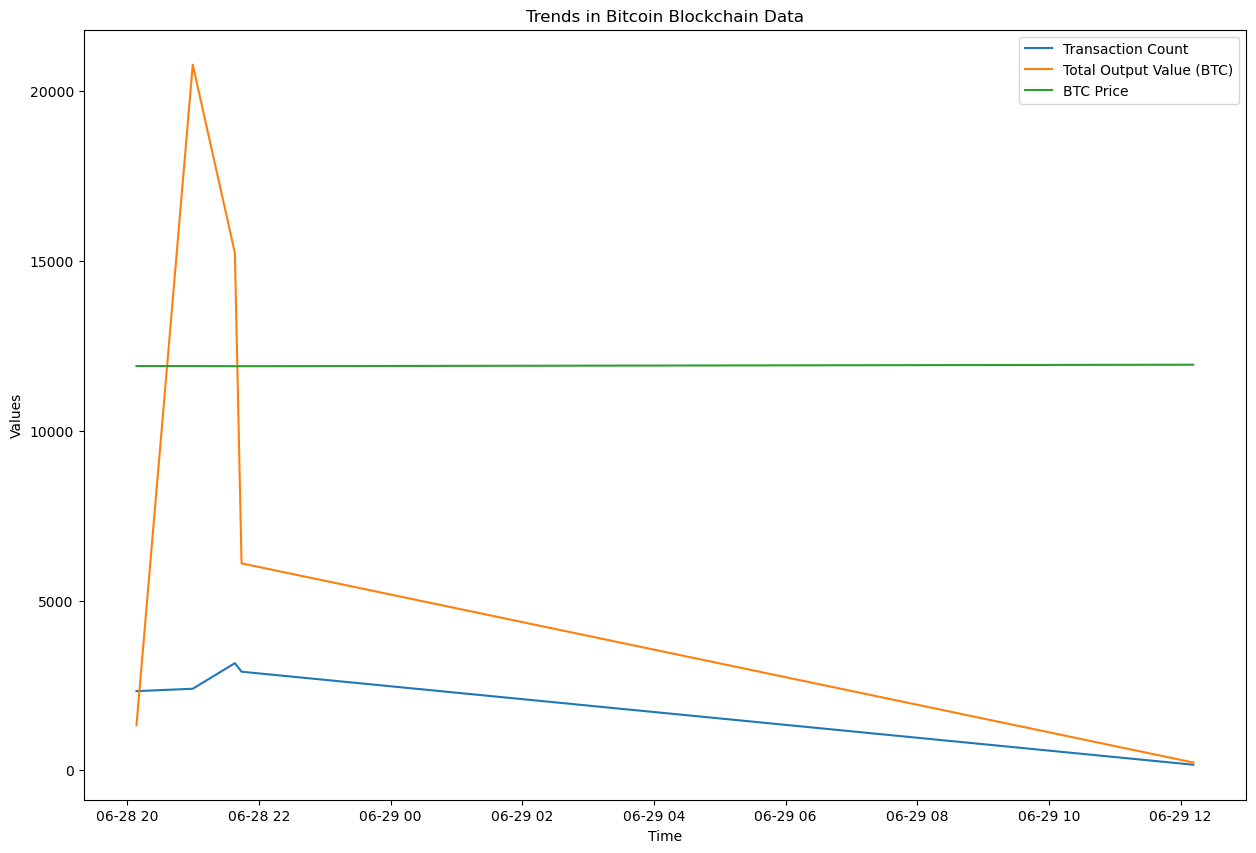

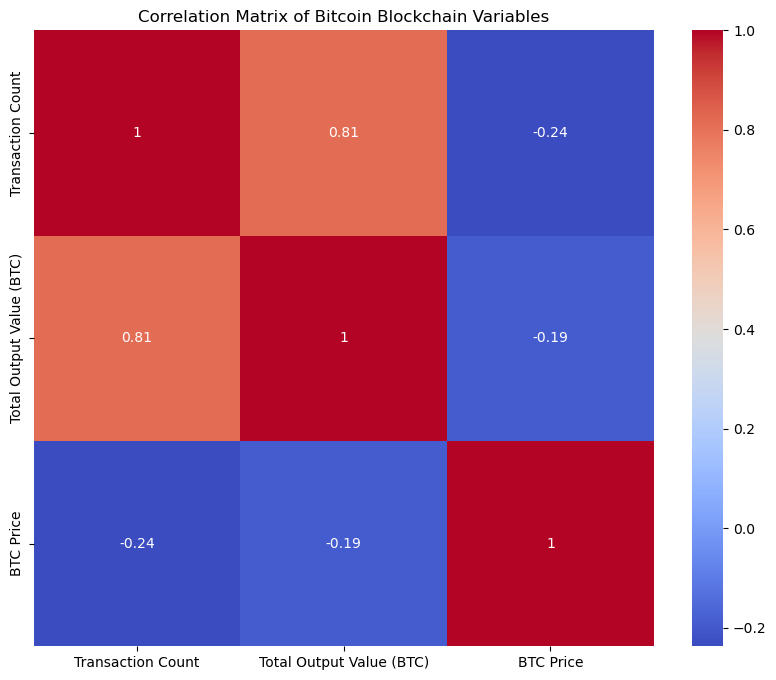

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'Time' to datetime format and set it as index
block_df['Time'] = pd.to_datetime(block_df['Time'])
block_df.set_index('Time', inplace=True)

# Selecting relevant columns for visualization
columns_to_visualize = ['Transaction Count', 'Total Output Value (BTC)', 'BTC Price', 'Estimated Transaction Fee (BTC)']

# Plotting trends over time
plt.figure(figsize=(15, 10))
for column in columns_to_visualize:
    sns.lineplot(data=block_df, x=block_df.index, y=column, label=column)

plt.title('Trends in Bitcoin Blockchain Data')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

# Creating a correlation matrix
correlation_matrix = block_df[columns_to_visualize].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Bitcoin Blockchain Variables')
plt.show()


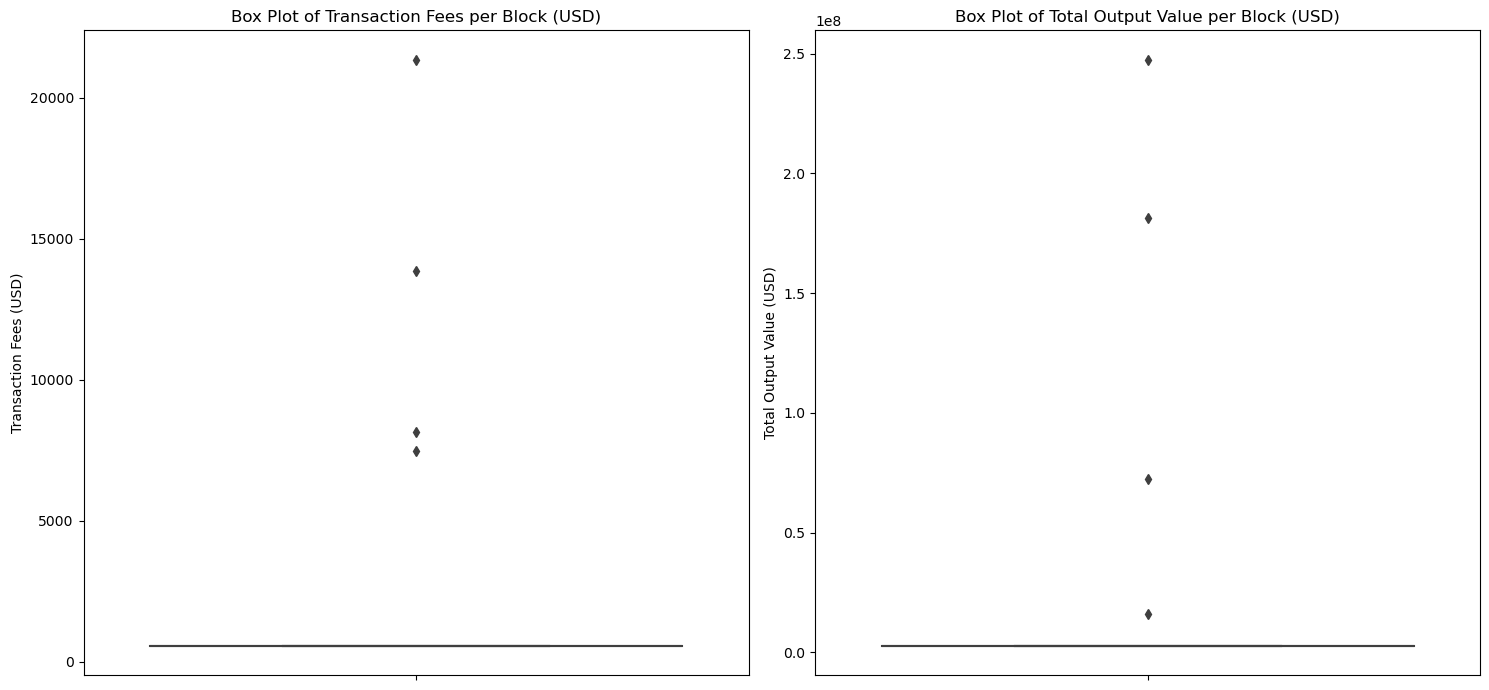

In [88]:
# Creating box plots for transaction fee and total output value
plt.figure(figsize=(15, 7))

# Box plot for Transaction Fees
plt.subplot(1, 2, 1)
sns.boxplot(y=block_df['Estimated Transaction Fees (USD)'])
plt.title('Box Plot of Transaction Fees per Block (USD)')
plt.ylabel('Transaction Fees (USD)')

# Box plot for Total Output Value
plt.subplot(1, 2, 2)
sns.boxplot(y=block_df['Total Output Value (USD)'])
plt.title('Box Plot of Total Output Value per Block (USD)')
plt.ylabel('Total Output Value (USD)')

plt.tight_layout()
plt.show()